In [1]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import mne
mne.set_log_level('WARNING')

In [2]:
def print_formatted_struct(data, indent_level=0):
    """
    Recursively print the fields of a MATLAB struct loaded into Python.
    Prints the size of arrays instead of their content.
    """
    indent = '-' * indent_level

    # Check if the data is a structured numpy array
    if isinstance(data, np.ndarray):
        # Check if it's a structured array (with named fields)
        if data.dtype.names is not None:
            for name in data.dtype.names:
                print(f"{indent}{name}:")
                # Recursively print each field
                field_data = data[name][0, 0]  # Adjust indexing based on your data's structure
                print_formatted_struct(field_data, indent_level + 1)
        else:
            # Print the size of the array
            print(f"{indent}[Array of shape {data.shape}]")
    elif isinstance(data, dict):
        for key, value in data.items():
            print(f"{indent}{key}:")
            print_formatted_struct(value, indent_level + 1)
    else:
        # Print summary for other data types
        print(f"{indent}{str(data)}")

In [3]:
class Run:
    def __init__(self, data, markers, cue_id, fs, classes):
        """
        Initialize the Run class with the specified parameters.

        :param data: The data for this run, expected to be in a specific format (e.g., (xxxxx, 15) array)
        :param marker: List of timestamps for when a cue was given
        :param cue_id: List of cue IDs (e.g., 1 for left hand, 2 for right hand)
        """
        self.data = data
        self.markers = markers
        self.cue_id = cue_id
        self.fs = fs
        self.classes = classes
    def __str__(self):
        """
        String representation of the Run instance.
        """
        return f"Run: \n\tData: {self.data.shape}, \n\tMarkers: {self.markers.shape}, \n\tCue IDs: {self.cue_id.shape}, \n\tSampling Frequency: {self.fs}, \n\tClasses: {self.classes}"
    

class Subject:
    def __init__(self, subject_number, num_electrodes, sampling_frequency, classes):
        """
        Initialize the Subject class with the specified parameters.

        :param subject_number: Unique identifier for the subject
        :param num_electrodes: Number of electrodes used
        :param sampling_frequency: Sampling frequency of the data
        """
        self.subject_number = subject_number
        self.num_electrodes = num_electrodes
        self.sampling_frequency = sampling_frequency
        self.runs = []
        self.classes = classes
    def __str__(self):
        """
        String representation of the Subject instance.
        """
        return f"Subject: \n\tSubject Number: {self.subject_number}, \n\tClasses: {self.classes}, \n\tNumber of Runs: {self.num_runs}"

    def __getitem__(self, run_index):
        """
        Retrieve a run by its index using indexing syntax.

        :param run_index: Index of the run in the list of runs
        :return: The Run instance at the specified index
        """
        if 0 <= run_index < len(self.runs):
            return self.runs[run_index]
        else:
            raise IndexError("Run index out of range.")


    def add_run(self, data, markers, cue_id, fs, classes):
        """
        Add a new Run instance to the subject.

        :param data: Data for the run
        :param label: Label for the run
        :param classes: Classes involved in the run
        :param cue: Cue associated with the run
        """
        new_run = Run(data, markers, cue_id, fs, classes)
        self.runs.append(new_run)

    def get_run_data(self, run_index):
        """
        Retrieve the data for a specific run.

        :param run_index: Index of the run in the list
        :return: Data of the specified run
        """
        if 0 <= run_index < len(self.runs):
            return self.runs[run_index].data
        else:
            raise IndexError("Run index out of range.")

    def get_electrode_data(self, run_index, electrode_number):
        """
        Retrieve data for a specific electrode from a specific run.

        :param run_index: Index of the run
        :param electrode_number: Electrode number (0 to num_electrodes - 1)
        :return: Data for the specified electrode in the specified run
        """
        if not (0 <= run_index < len(self.runs)):
            raise IndexError("Run index out of range.")

        run_data = self.runs[run_index].data
        if not (0 <= electrode_number < self.num_electrodes):
            raise ValueError("Invalid electrode number. Must be between 0 and {}.".format(self.num_electrodes - 1))

        return run_data[:, electrode_number]

    @property
    def num_runs(self):
        """
        Return the number of runs for the subject.
        """
        return len(self.runs)

class Subjects:
    def __init__(self):
        """
        Initialize the Subjects class to hold a collection of Subject instances.
        """
        self.subjects = {}
        
    def __str__(self):
        """
        String representation of the Subjects collection, sorted by subject number.
        """
        sorted_subjects = sorted(self.subjects.items(), key=lambda x: x[0])
        subjects_info = [str(subject) for _, subject in sorted_subjects]
        return "Subjects: "+'\n\t'.join(subjects_info)
        
    def __getitem__(self, subject_number):
        """
        Retrieve a subject by its number using indexing syntax.

        :param subject_number: The unique identifier for the subject
        :return: The Subject instance corresponding to the given subject number
        """
        if subject_number in self.subjects:
            return self.subjects[subject_number]
        else:
            raise KeyError(f"Subject with number {subject_number} not found.")

    def add_subject(self, subject):
        """
        Add a new Subject instance to the collection.

        :param subject: An instance of the Subject class
        """
        if subject.subject_number in self.subjects:
            raise ValueError(f"Subject with number {subject.subject_number} already exists.")
        self.subjects[subject.subject_number] = subject

    def get_subject(self, subject_number):
        """
        Retrieve a subject by its number.

        :param subject_number: The unique identifier for the subject
        :return: The Subject instance corresponding to the given subject number
        """
        if subject_number in self.subjects:
            return self.subjects[subject_number]
        else:
            raise ValueError(f"Subject with number {subject_number} not found.")


In [4]:
def get_data(data, run):
    d = data[0,run]
    data = d['X'][0,0]
    labels = d['y'][0,0]
    trial = d['trial'][0,0]
    fs = int(d['fs'][0,0][0,0])
    classes = [d['classes'][0,0][0][i][0] for i in range(len(d['classes'][0,0][0]))]
    return data, labels, trial, fs, classes

In [5]:
subjects = Subjects()
directory = "data/"
for file in os.listdir(os.fsencode(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"): 
        mat =  loadmat(os.path.join(directory, filename))
        data = mat["data"]
        subjectnumber = int(filename[1:3])
        if data.shape[1]==5:
            signal, markers, cue_id, fs, classes = get_data(data, 0)
            sub = Subject(subjectnumber, signal.shape[1], fs, classes)
            sub.add_run(signal, markers, cue_id, fs, classes)
            for r in range(1, 5):
                signal, markers, cue_id, fs ,classes = get_data(data, r)
                sub.add_run(signal, markers, cue_id, fs, classes)
            subjects.add_subject(sub)
            

In [6]:

print(subjects)


Subjects: Subject: 
	Subject Number: 1, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 2, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 3, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 4, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 5, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 6, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 7, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 8, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 9, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 10, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 11, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5


# MNE


In [7]:
import mne

<Info | 7 non-empty values
 bads: []
 ch_names: EEG01, EEG02, EEG03, EEG04, EEG05, EEG06, EEG07, EEG08, EEG09, ...
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 512.0 Hz
>


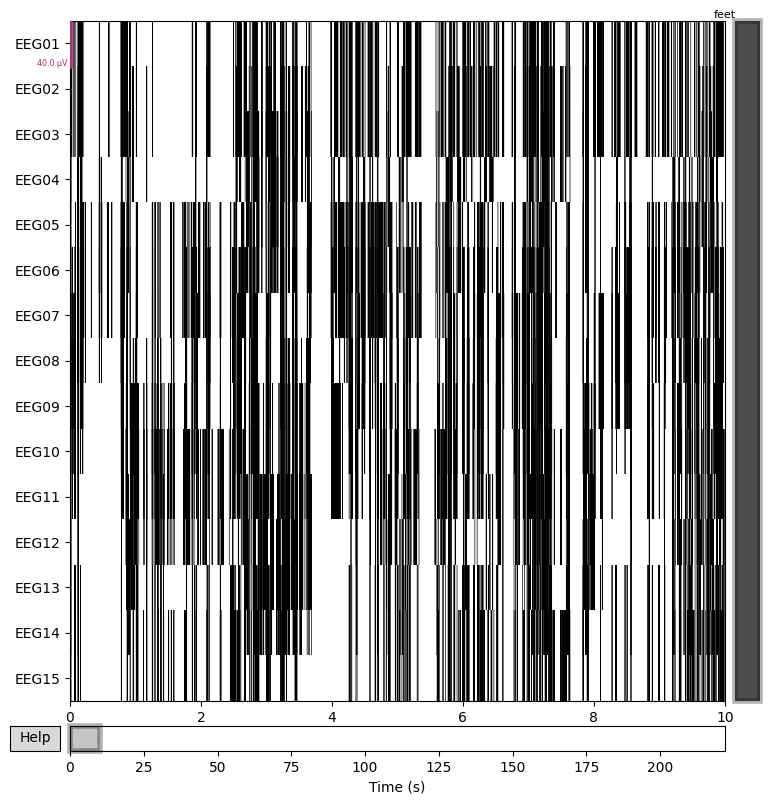

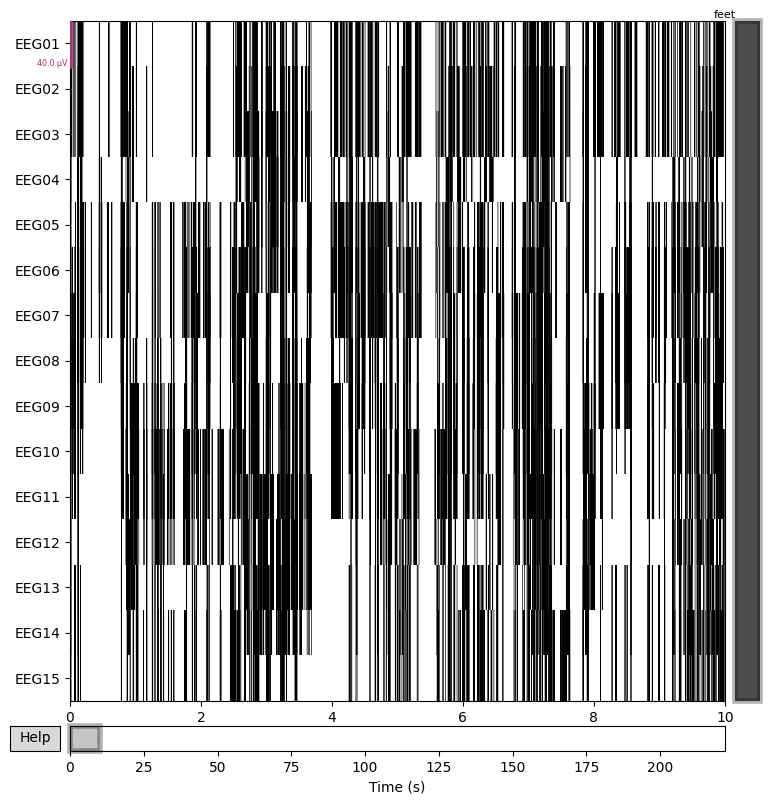

In [8]:
def create_info_from_subject(subject: Subject):
    if not isinstance(subject, Subject):
        raise TypeError("Expected a Subject instance")
    
    ch_names = [f"EEG{i:02d}" for i in range(1, subject.num_electrodes + 1)]
    ch_types = ["eeg"] * subject.num_electrodes
    info = mne.create_info(ch_names=ch_names, sfreq=subject.sampling_frequency, ch_types=ch_types)
    return info

def create_raw_from_subject(subject: Subject, run: int):
    info = create_info_from_subject(subject)
    data = subject.get_run_data(run)
    raw = mne.io.RawArray(data.T, info)

    run_object = subject[run]
    events = np.column_stack(
        (
            np.array(run_object.cue_id.T, dtype=int),
            np.zeros(20, dtype=int),
            np.array(run_object.markers.T, dtype=int),           
        )
    )
    events = events.reshape((20, 3))
    event_dict={}
    for i in range(len(run_object.classes)):
        event_dict[run_object.classes[i]]=i+1
    
    return raw, events, event_dict
def create_epochs_from_subject(subject: Subject, tmin=-1, tmax=6, baseline=None, preload=True, picks=("all")):
    epochs_list = []
    for run in range(subject.num_runs):
        try:
            raw, events, event_dict = create_raw_from_subject(subject, run)
            if picks != "all":
                picks = list(picks)
            epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, baseline=baseline, preload=preload, picks=picks)
            epochs_list.append(epochs)
        except Exception as e:
            print(f"Error processing run {run}: {e}")

    if epochs_list:
        epochs = mne.concatenate_epochs(epochs_list)
        return epochs
    else:
        raise ValueError("No valid epochs were created from the runs.")
info = create_info_from_subject(subjects[1])
print(info)
raw, events, event_dict = create_raw_from_subject(subjects[2], 0)
raw.plot(events=events, event_id = event_dict)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper


tmin, tmax = -1, 6
raw, events, event_dict = create_raw_from_subject(subjects[2], 0)

epochs = mne.Epochs(
    raw,
    events,
    event_dict,
    tmin - 0.5,
    tmax + 0.5,
    #picks = "all",
    picks=("EEG01", "EEG02", "EEG03"),
    #picks = ("EEG01"),
    baseline=None,
    preload=True,
)

epochs


Number of events,20
Events,feet: 10right hand: 10
Time range,-1.500 – 6.500 s
Baseline,off


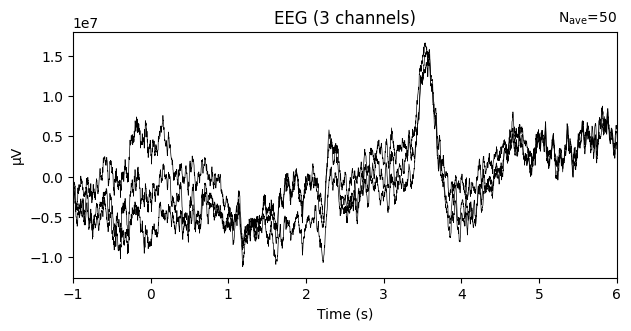

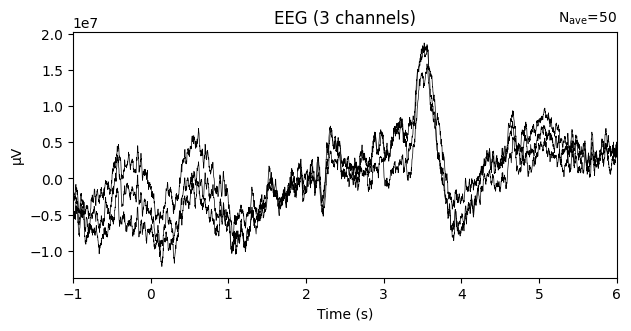

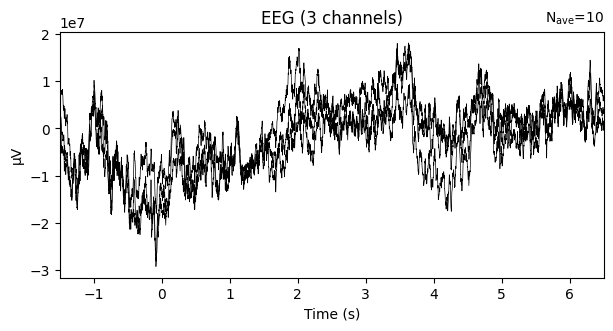

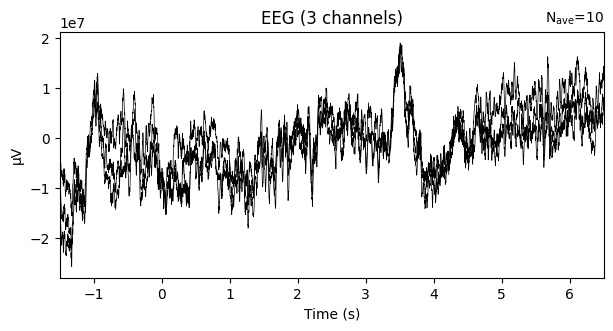

In [10]:

#reject_criteria = dict(eeg=1000000000e-6)  # 100 µV
#epochs.drop_bad(reject=reject_criteria)
#epochs.plot_drop_log()
#Rejection does not work for some reason, it is not predictable, sometimes it drops everything, sometimes a bit, sometimes nothing on the same data
big_epochs = create_epochs_from_subject(subjects[2], picks=("EEG01", "EEG02", "EEG03"))
big_rhand_avg = big_epochs["right hand"].average()
big_feet_avg = big_epochs["feet"].average()
rhand_avg = epochs["right hand"].average()
feet_avg = epochs["feet"].average()
big_rhand_avg.plot()
big_feet_avg.plot()
rhand_avg.plot()
feet_avg.plot()

plt.show()


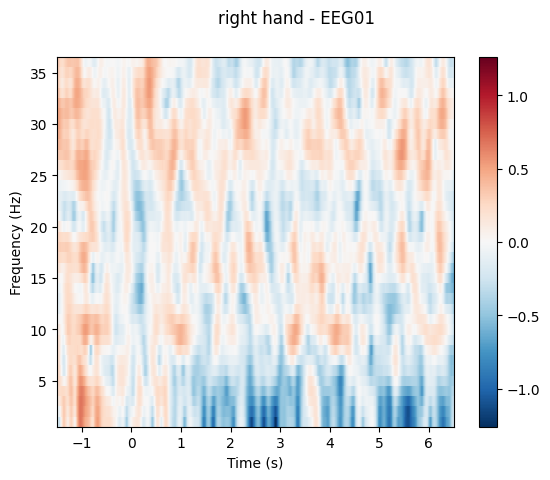

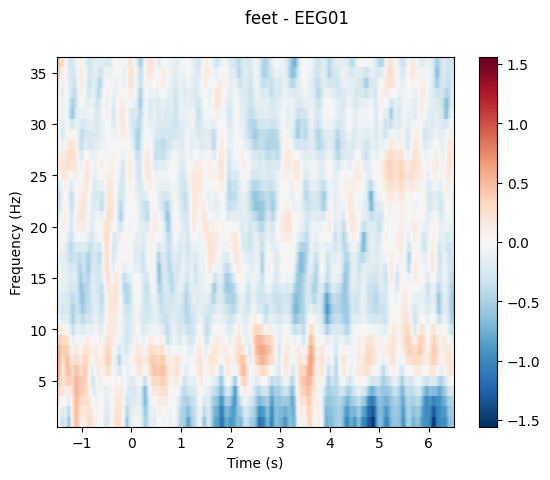

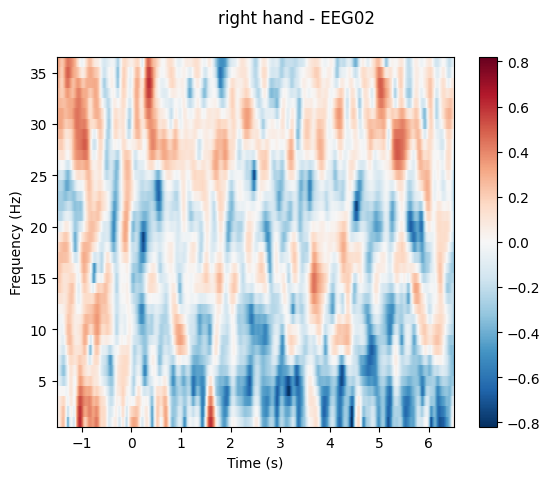

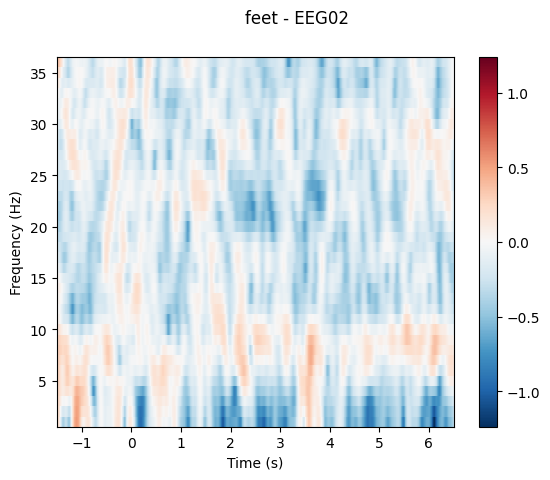

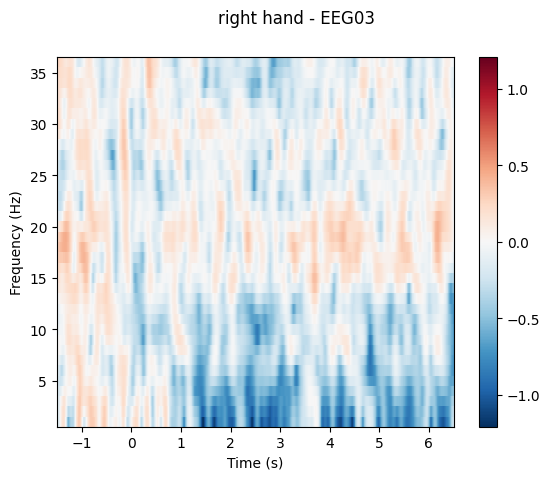

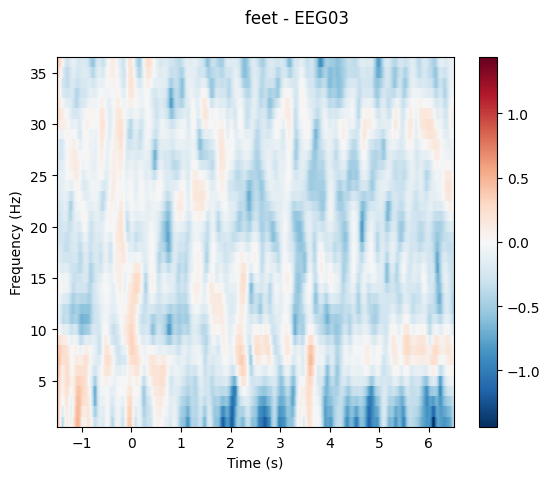

In [11]:

def plot_spectrogram(epochs, channel, event_type):
    # Select epochs for the specific event type
    selected_epochs = epochs[event_type]

    # Define frequencies of interest
    freqs = np.linspace(1, 36, 36)  # From 1 to 36 Hz in 36 steps
    n_cycles = freqs / 2  # Different number of cycle per frequency

    # Compute the TFR
    power = mne.time_frequency.tfr_morlet(selected_epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                                          return_itc=False, decim=3, n_jobs=1)

    # Pick the channel (use the index or channel name)
    power.pick_channels([channel])

    # Plot the TFR for the channel
    power.plot([0], baseline=(-0.5, 0), mode='logratio', title=f'{event_type} - {channel}')

# Example usage:
channel_list = ["EEG01", "EEG02", "EEG03"]
event_types = ["right hand", "feet"]

for channel in channel_list:
    for event in event_types:
        plot_spectrogram(epochs, channel, event)



c:\Users\tore-\OneDrive - NTNU\Termin 9\TTK16\TTK7-MI-t-f-analysis\ttk7\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


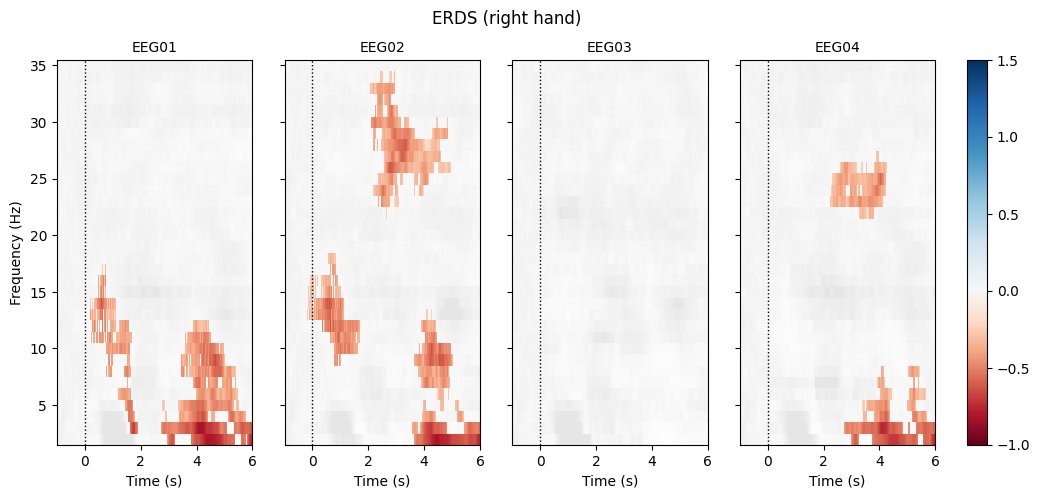

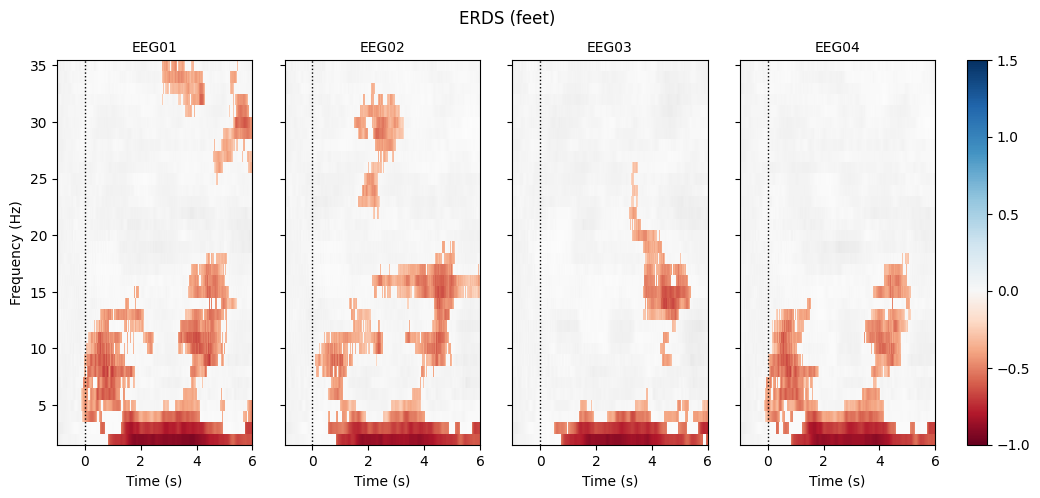

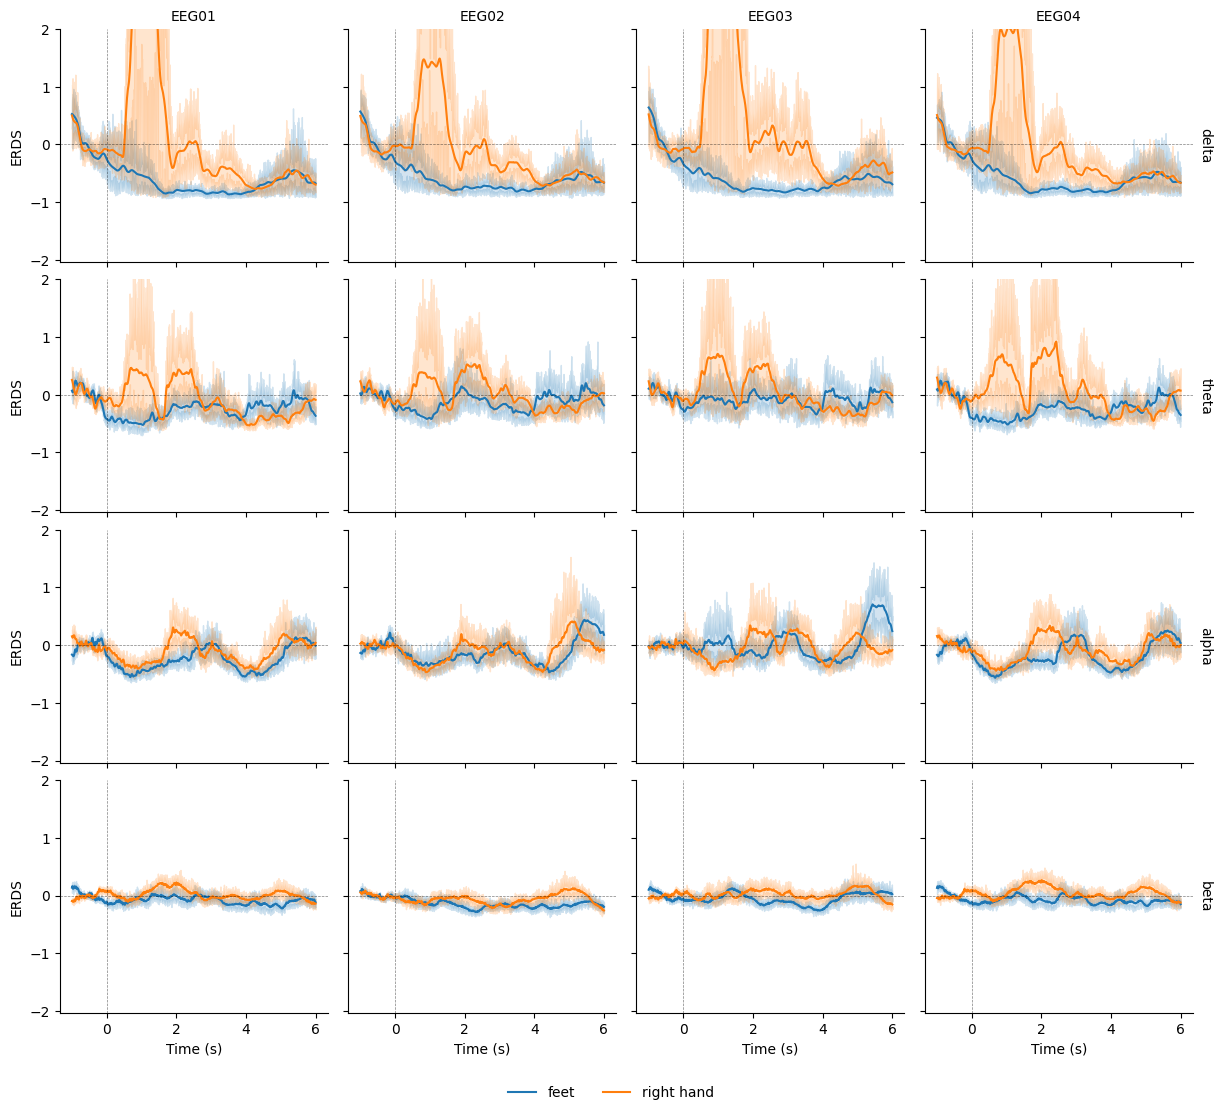

In [12]:
def compute_ERDS(subject: Subject, run:  int, tmin: int, tmax: int, channel_picks, vmin=-1,vmax=1.5):
    if channel_picks == "all":
        channel_picks = [f"EEG{i:02d}" for i in range(1, subject.num_electrodes + 1)]
    raw, events, event_dict = create_raw_from_subject(subject, run)

    epochs = mne.Epochs( #Define epochs
        raw,
        events,
        event_dict,
        tmin - 0.5,
        tmax + 0.5,
        picks=channel_picks,
        baseline=None,
        preload=True,
    )

    # Set up frequency parameters for the TF Decomposition
    freqs = np.arange(2, 36)  # frequencies from 2-35Hz
    baseline = (tmin, 0)  # baseline interval (in s)
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    kwargs = dict(
        n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
    ) 

    tfr = tfr_multitaper(
        epochs,
        freqs=freqs,
        n_cycles=freqs,
        use_fft=True,
        return_itc=False,
        average=False,
        decim=2,
    )
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

    for event in event_dict:
        # select desired epochs for visualization
        tfr_ev = tfr[event]
        numCoulumns = len(tfr_ev.ch_names)+1
        wr = [10]*(numCoulumns-1)
        wr.append(1)
        fig, axes = plt.subplots(
            1, numCoulumns, figsize=(12,numCoulumns), gridspec_kw={"width_ratios": wr}
        )
        for ch, ax in enumerate(axes[:-1]):  # for each channel
            # positive clusters
            _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
            # negative clusters
            _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

            # note that we keep clusters with p <= 0.05 from the combined clusters
            # of two independent tests; in this example, we do not correct for
            # these two comparisons
            c = np.stack(c1 + c2, axis=2)  # combined clusters
            p = np.concatenate((p1, p2))  # combined p-values
            mask = c[..., p <= 0.05].any(axis=-1)

            # plot TFR (ERDS map with masking)
            tfr_ev.average().plot(
                [ch],
                cmap="RdBu",
                cnorm=cnorm,
                axes=ax,
                colorbar=False,
                show=False,
                mask=mask,
                mask_style="mask",
            )

            ax.set_title(epochs.ch_names[ch], fontsize=10)
            ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
            if ch != 0:
                ax.set_ylabel("")
                ax.set_yticklabels("")
        fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
        fig.suptitle(f"ERDS ({event})")
        plt.show()

   
    df = tfr.to_data_frame(time_format=None)
    df.head()

    df = tfr.to_data_frame(time_format=None, long_format=True)

    # Map to frequency bands:
    freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
    df["band"] = pd.cut(
        df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
    )

    # Filter to retain only relevant frequency bands:
    freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
    df = df[df.band.isin(freq_bands_of_interest)]
    df["band"] = df["band"].cat.remove_unused_categories()

    # Order channels for plotting:
    #df["channel"] = df["channel"].cat.reorder_categories(("EEG01", "EEG02", "EEG03"), ordered=True)

    g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
    g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
    axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, y=0, **axline_kw)
    g.map(plt.axvline, x=0, **axline_kw)
    g.set(ylim=(None, 2.0))
    g.set_axis_labels("Time (s)", "ERDS")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.add_legend(ncol=2, loc="lower center")
    g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    plt.show()

    




picks = ("EEG01", "EEG02", "EEG03", "EEG04")
#picks = "all"
compute_ERDS(subject=subjects[1], run=0, tmin=-1, tmax=6, channel_picks=picks)



# Creating the ERP and further analysis

### ERP

In [13]:
epochs = create_epochs_from_subject(subjects[1])

erp_hands = epochs["right hand"].average()
erp_feet = epochs["feet"].average()


### Decomposition Analysis (MVMD, MEMD) 

In [14]:

import numpy as np
from scipy.interpolate import interp1d,CubicSpline
from math import pi,sqrt,sin,cos
import warnings
import sys



# =============================================================================

def hamm(n,base):
    seq = np.zeros((1,n))
    
    if 1 < base:
        seed = np.arange(1,n+1)
        base_inv = 1/base
        while any(x!=0 for x in seed):
            digit = np.remainder(seed[0:n],base)
            seq = seq + digit*base_inv
            base_inv = base_inv/base
            seed = np.floor (seed/base)
    else:
        temp = np.arange(1,n+1)
        seq = (np.remainder(temp,(-base+1))+0.5)/(-base)
        
    return(seq)

# =============================================================================

def zero_crossings(x):
    indzer = np.where(x[0:-1]*x[1:]<0)[0]
    
    if any(x == 0):
        iz = np.where(x==0)[0]
        if any(np.diff(iz)==1):
            zer = x == 0
            dz = np.diff([0,zer,0])
            debz = np.where(dz == 1)[0]
            finz = np.where(dz == -1)[0]-1
            indz = np.round((debz+finz)/2)
        else:
            indz = iz
        indzer = np.sort(np.concatenate((indzer,indz)))
        
    return(indzer)

# =============================================================================

#defines new extrema points to extend the interpolations at the edges of the
#signal (mainly mirror symmetry)
def boundary_conditions(indmin,indmax,t,x,z,nbsym):
    lx = len(x)-1
    end_max = len(indmax)-1
    end_min = len(indmin)-1
    indmin = indmin.astype(int)
    indmax = indmax.astype(int)

    if len(indmin) + len(indmax) < 3:
        mode = 0
        tmin=tmax=zmin=zmax=None
        return(tmin,tmax,zmin,zmax,mode)
    else:
        mode=1 #the projected signal has inadequate extrema
    #boundary conditions for interpolations :
    if indmax[0] < indmin[0]:
        if x[0] > x[indmin[0]]:
            lmax = np.flipud(indmax[1:min(end_max+1,nbsym+1)])
            lmin = np.flipud(indmin[:min(end_min+1,nbsym)])
            lsym = indmax[0]

        else:
            lmax = np.flipud(indmax[:min(end_max+1,nbsym)])
            lmin = np.concatenate((np.flipud(indmin[:min(end_min+1,nbsym-1)]),([0])))
            lsym = 0

    else:
        if x[0] < x[indmax[0]]:
            lmax = np.flipud(indmax[:min(end_max+1,nbsym)])
            lmin = np.flipud(indmin[1:min(end_min+1,nbsym+1)])
            lsym = indmin[0]

        else:
            lmax = np.concatenate((np.flipud(indmax[:min(end_max+1,nbsym-1)]),([0])))
            lmin = np.flipud(indmin[:min(end_min+1,nbsym)])
            lsym = 0

    if indmax[-1] < indmin[-1]:
        if x[-1] < x[indmax[-1]]:
            rmax = np.flipud(indmax[max(end_max-nbsym+1,0):])
            rmin = np.flipud(indmin[max(end_min-nbsym,0):-1])
            rsym = indmin[-1]

        else:
            rmax = np.concatenate((np.array([lx]),np.flipud(indmax[max(end_max-nbsym+2,0):])))
            rmin = np.flipud(indmin[max(end_min-nbsym+1,0):])
            rsym = lx

    else:
        if x[-1] > x[indmin[-1]]:
            rmax = np.flipud(indmax[max(end_max-nbsym,0):-1])
            rmin = np.flipud(indmin[max(end_min-nbsym+1,0):])
            rsym = indmax[-1]

        else:
            rmax = np.flipud(indmax[max(end_max-nbsym+1,0):])
            rmin = np.concatenate((np.array([lx]),np.flipud(indmin[max(end_min-nbsym+2,0):])))
            rsym = lx

    tlmin = 2*t[lsym]-t[lmin]
    tlmax = 2*t[lsym]-t[lmax]
    trmin = 2*t[rsym]-t[rmin]
    trmax = 2*t[rsym]-t[rmax]

    #in case symmetrized parts do not extend enough
    if tlmin[0] > t[0] or tlmax[0] > t[0]:
        if lsym == indmax[0]:
            lmax = np.flipud(indmax[:min(end_max+1,nbsym)])
        else:
            lmin = np.flipud(indmin[:min(end_min+1,nbsym)])
        if lsym == 1:
            sys.exit('bug')
        lsym = 0
        tlmin = 2*t[lsym]-t[lmin]
        tlmax = 2*t[lsym]-t[lmax]
        
    if trmin[-1] < t[lx] or trmax[-1] < t[lx]:
        if rsym == indmax[-1]:
            rmax = np.flipud(indmax[max(end_max-nbsym+1,0):])
        else:
            rmin = np.flipud(indmin[max(end_min-nbsym+1,0):])
        if rsym == lx:
            sys.exit('bug')
        rsym = lx
        trmin = 2*t[rsym]-t[rmin]
        trmax = 2*t[rsym]-t[rmax]

    zlmax =z[lmax,:]
    zlmin =z[lmin,:]
    zrmax =z[rmax,:]
    zrmin =z[rmin,:]

    tmin = np.hstack((tlmin,t[indmin],trmin))
    tmax = np.hstack((tlmax,t[indmax],trmax))
    zmin = np.vstack((zlmin,z[indmin,:],zrmin))
    zmax = np.vstack((zlmax,z[indmax,:],zrmax))

    return(tmin,tmax,zmin,zmax,mode)

# =============================================================================

# computes the mean of the envelopes and the mode amplitude estimate
def envelope_mean(m,t,seq,ndir,N,N_dim): #new

    NBSYM = 2
    count = 0

    env_mean=np.zeros((len(t),N_dim))
    amp = np.zeros((len(t)))
    nem = np.zeros((ndir))
    nzm = np.zeros((ndir))
    
    dir_vec = np.zeros((N_dim,1))
    for it in range(0,ndir):
        if N_dim !=3:     # Multivariate signal (for N_dim ~=3) with hammersley sequence
            #Linear normalisation of hammersley sequence in the range of -1.00 - 1.00
            b=2*seq[it,:]-1 
            
            # Find angles corresponding to the normalised sequence
            tht = np.arctan2(np.sqrt(np.flipud(np.cumsum(b[:0:-1]**2)))\
                             ,b[:N_dim-1]).transpose()
            
            # Find coordinates of unit direction vectors on n-sphere
            dir_vec[:,0] = np.cumprod(np.concatenate(([1],np.sin(tht))))
            dir_vec[:N_dim-1,0] =  np.cos(tht)*dir_vec[:N_dim-1,0]
            
        else:     # Trivariate signal with hammersley sequence
            # Linear normalisation of hammersley sequence in the range of -1.0 - 1.0
            tt = 2*seq[it,0]-1
            if tt>1:
                tt=1
            elif tt<-1:
                tt=-1         
            
            # Normalize angle from 0 - 2*pi
            phirad = seq[it,1]*2*pi
            st = sqrt(1.0-tt*tt)
            
            dir_vec[0]=st*cos(phirad)
            dir_vec[1]=st*sin(phirad)
            dir_vec[2]=tt
           
        # Projection of input signal on nth (out of total ndir) direction vectors
        y  = np.dot(m,dir_vec)

        # Calculates the extrema of the projected signal
        indmin,indmax = local_peaks(y)      

        nem[it] = len(indmin) + len(indmax)
        indzer = zero_crossings(y)
        nzm[it] = len(indzer)

        tmin,tmax,zmin,zmax,mode = boundary_conditions(indmin,indmax,t,y,m,NBSYM)
        
        # Calculate multidimensional envelopes using spline interpolation
        # Only done if number of extrema of the projected signal exceed 3
        if mode:
            fmin = CubicSpline(tmin,zmin,bc_type='not-a-knot')
            env_min = fmin(t)
            fmax = CubicSpline(tmax,zmax,bc_type='not-a-knot')
            env_max = fmax(t)
            amp = amp + np.sqrt(np.sum(np.power(env_max-env_min,2),axis=1))/2
            env_mean = env_mean + (env_max+env_min)/2
        else:     # if the projected signal has inadequate extrema
            count=count+1
            
    if ndir>count:
        env_mean = env_mean/(ndir-count)
        amp = amp/(ndir-count)
    else:
        env_mean = np.zeros((N,N_dim))
        amp = np.zeros((N))
        nem = np.zeros((ndir))
        
    return(env_mean,nem,nzm,amp)

# =============================================================================

#Stopping criterion
def stop(m,t,sd,sd2,tol,seq,ndir,N,N_dim):
    try:
        env_mean,nem,nzm,amp = envelope_mean(m,t,seq,ndir,N,N_dim)
        sx = np.sqrt(np.sum(np.power(env_mean,2),axis=1))
        
        if all(amp):     # something is wrong here
            sx = sx/amp
            
        if ((np.mean(sx > sd) > tol or any(sx > sd2)) and any(nem > 2)) == False:
            stp = 1
        else:
            stp = 0
    except:
        env_mean = np.zeros((N,N_dim))
        stp = 1
        
    return(stp,env_mean)
    
# =============================================================================
    
def fix(m,t,seq,ndir,stp_cnt,counter,N,N_dim):
    try:
        env_mean,nem,nzm,amp = envelope_mean(m,t,seq,ndir,N,N_dim)
        
        if all(np.abs(nzm-nem)>1):
            stp = 0
            counter = 0
        else:
            counter = counter+1
            stp = (counter >= stp_cnt)
    except:
        env_mean = np.zeros((N,N_dim))
        stp = 1
        
    return(stp,env_mean,counter)

# =============================================================================

def peaks(X):
    dX = np.sign(np.diff(X.transpose())).transpose()
    locs_max = np.where(np.logical_and(dX[:-1] >0,dX[1:] <0))[0]+1
    pks_max = X[locs_max]
    
    return(pks_max,locs_max)

# =============================================================================

def local_peaks(x):
    if all(x < 1e-5):
        x=np.zeros((1,len(x)))

    m = len(x)-1
    
    # Calculates the extrema of the projected signal
    # Difference between subsequent elements:
    dy = np.diff(x.transpose()).transpose()
    a = np.where(dy!=0)[0]
    lm = np.where(np.diff(a)!=1)[0] + 1
    d = a[lm] - a[lm-1] 
    a[lm] = a[lm] - np.floor(d/2)
    a = np.insert(a,len(a),m)
    ya  = x[a]
    
    if len(ya) > 1:
        # Maxima
        pks_max,loc_max=peaks(ya)
        # Minima
        pks_min,loc_min=peaks(-ya)
        
        if len(pks_min)>0:
            indmin = a[loc_min]
        else:
            indmin = np.asarray([])
            
        if len(pks_max)>0:
            indmax = a[loc_max]
        else:
            indmax = np.asarray([])
    else:
        indmin=np.array([])
        indmax=np.array([])
        
    return(indmin, indmax)

# =============================================================================

def stop_emd(r,seq,ndir,N_dim):
    ner = np.zeros((ndir,1))
    dir_vec = np.zeros((N_dim,1))
    
    for it in range(0,ndir):
        if N_dim != 3: # Multivariate signal (for N_dim ~=3) with hammersley sequence
            # Linear normalisation of hammersley sequence in the range of -1.00 - 1.00
            b=2*seq[it,:]-1
            
            # Find angles corresponding to the normalised sequence
            tht = np.arctan2(np.sqrt(np.flipud(np.cumsum(b[:0:-1]**2)))\
                             ,b[:N_dim-1]).transpose()
            
            # Find coordinates of unit direction vectors on n-sphere
            dir_vec[:,0] = np.cumprod(np.concatenate(([1],np.sin(tht))))
            dir_vec[:N_dim-1,0] =  np.cos(tht)*dir_vec[:N_dim-1,0]
    
        else: # Trivariate signal with hammersley sequence
            # Linear normalisation of hammersley sequence in the range of -1.0 - 1.0
            tt = 2*seq[it,0]-1
            if tt>1:
                tt=1
            elif tt<-1:
                tt=-1  
            
            # Normalize angle from 0 - 2*pi
            phirad = seq[it,1]*2*pi
            st = sqrt(1.0-tt*tt)
            
            dir_vec[0]=st*cos(phirad)
            dir_vec[1]=st*sin(phirad)
            dir_vec[2]=tt
        # Projection of input signal on nth (out of total ndir) direction
        # vectors
        y = np.dot(r,dir_vec)

        # Calculates the extrema of the projected signal
        indmin, indmax = local_peaks(y)

        ner[it] = len(indmin) + len(indmax)
    
    # Stops if the all projected signals have less than 3 extrema
    stp = all(ner<3)
    
    return (stp)

# =============================================================================

def is_prime(x):
    if x == 2:
        return True
    else:
        for number in range (3,x): 
            if x % number == 0 or x % 2 == 0:
         #print number
                return (False)
            
# =============================================================================
                
        return (True)
def nth_prime(n):
    lst = [2]
    for i in range(3,104745):
        if is_prime(i) == True:
            lst.append(i)
            if len(lst) == n:
                return (lst)
# =============================================================================

def set_value(*args):
    args = args[0]
    narg = len(args)
    q = args[0]
    
    ndir=stp_cnt=MAXITERATIONS=sd=sd2=tol = None
    stp_crit,stp_vec,base = [],[],[]
                                          
    if narg == 0:
        sys.exit('Not enough input arguments.')
    elif narg > 4:
        sys.exit('Too many input arguments.')
    elif narg == 1:
        ndir = 64     # default
        stp_crit = 'stop'     # default
        stp_vec = np.array([0.075,0.75,0.075])     # default
        sd,sd2,tol = stp_vec[0],stp_vec[1],stp_vec[2]        
    elif narg == 2:
        ndir = args[1]
        stp_crit = 'stop'     # default
        stp_vec = np.array([0.075,0.75,0.075])     # default
        sd,sd2,tol = stp_vec[0],stp_vec[1],stp_vec[2]
    elif narg == 3:
        if args[1] != None:
            ndir = args[1]
        else:
            ndir = 64     # default
        stp_crit = args[2]
        if stp_crit == 'stop':
            stp_vec = np.array([0.075,0.75,0.075])     # default
            sd,sd2,tol = stp_vec[0],stp_vec[1],stp_vec[2]
        elif stp_crit == 'fix_h':
            stp_cnt = 2     # default
    elif narg == 4:
        if args[1] != None:
            ndir = args[1]
        else:
            ndir = 64     # default        
        stp_crit = args[2]        
        if args[2] == 'stop':
            stp_vec = args[3]
            sd,sd2,tol = stp_vec[0],stp_vec[1],stp_vec[2]
        elif args[2] == 'fix_h':
            stp_cnt = args[3]

    # Rescale input signal if required
    if len(q) == 0:                                                            # Doesn't do the same as the Matlab script
        sys.exit('emptyDataSet. Data set cannot be empty.')
    if np.shape(q)[0] < np.shape(q)[1]:
        q=q.transpose()
        
    # Dimension of input signal
    N_dim = np.shape(q)[1]
    if N_dim < 3:
        sys.exit('Function only processes the signal having more than 3.')
        
    # Length of input signal
    N = np.shape(q)[0]

    # Check validity of Input parameters                                       #  Doesn't do the same as the Matlab script
    if not isinstance(ndir,int) or ndir < 6:
        sys.exit('invalid num_dir. num_dir should be an integer greater than or equal to 6.')
    if not isinstance(stp_crit, str) or (stp_crit != 'stop' and stp_crit != 'fix_h'):
        sys.exit('invalid stop_criteria. stop_criteria should be either fix_h or stop')
    if not isinstance(stp_vec,(list, tuple, np.ndarray)) or any(x for x in stp_vec if not isinstance(x,(int, float, complex))):
        sys.exit('invalid stop_vector. stop_vector should be a list with three elements e.g. default is [0.75,0.75,0.75]')
    if stp_cnt != None:
        if not isinstance(stp_cnt,int) or stp_cnt < 0:
            sys.exit('invalid stop_count. stop_count should be a nonnegative integer.')

    # Initializations for Hammersley function
    base.append(-ndir)
    
    # Find the pointset for the given input signal
    if N_dim==3:
        base.append(2)
        seq = np.zeros((ndir,N_dim-1))
        for it in range(0,N_dim-1):
            seq[:,it] = hamm(ndir,base[it])
    else:
        #Prime numbers for Hammersley sequence
        prm = nth_prime(N_dim-1)
        for itr in range(1,N_dim):
            base.append(prm[itr-1])
        seq = np.zeros((ndir,N_dim))
        for it in range(0,N_dim):
            seq[:,it] = hamm(ndir,base[it])
    # Define t
    t = np.arange(1,N+1)
    #Counter
    nbit = 0
    MAXITERATIONS = 1000     #default    
    
    return(q,seq,t,ndir,N_dim,N,sd,sd2,tol,nbit,MAXITERATIONS,stp_crit,stp_cnt)
    
# =============================================================================
    
def memd(*args):
    x,seq,t,ndir,N_dim,N,sd,sd2,tol,nbit,MAXITERATIONS,stop_crit,stp_cnt = set_value(args)

    r=x
    n_imf=1
    q = []

    while stop_emd(r,seq,ndir,N_dim) == False:
        # current mode
        m = r
        
        # computation of mean and stopping criterion
        if stop_crit == 'stop':
            stop_sift,env_mean = stop(m,t,sd,sd2,tol,seq,ndir,N,N_dim)
        else:
            counter=0
            stop_sift,env_mean,counter = fix(m,t,seq,ndir,stp_cnt,counter,N,N_dim)
            
        # In case the current mode is so small that machine precision can cause
        # spurious extrema to appear
        if np.max(np.abs(m)) < (1e-10)*(np.max(np.abs(x))):
            if stop_sift == False:
                warnings.warn('emd:warning','forced stop of EMD : too small amplitude')
            else:
                print('forced stop of EMD : too small amplitude')
            break
        
        # sifting loop
        while stop_sift == False and nbit < MAXITERATIONS:
            # sifting
            m = m - env_mean
            
            # computation of mean and stopping criterion
            if stop_crit =='stop':
                stop_sift,env_mean = stop(m,t,sd,sd2,tol,seq,ndir,N,N_dim)
            else:
                stop_sift,env_mean,counter = fix(m,t,seq,ndir,stp_cnt,counter,N,N_dim)
        
            nbit=nbit+1
            
            if nbit == (MAXITERATIONS-1) and  nbit > 100:
                warnings.wanr('emd:warning','forced stop of sifting : too many erations')
            
        q.append(m.transpose())
        
        n_imf = n_imf+1
        r = r - m
        nbit = 0
        
    # Stores the residue
    q.append(r.transpose())
    q = np.asarray(q)
    #sprintf('Elapsed time: %f\n',toc);

    return(q)

<Figure size 640x480 with 0 Axes>

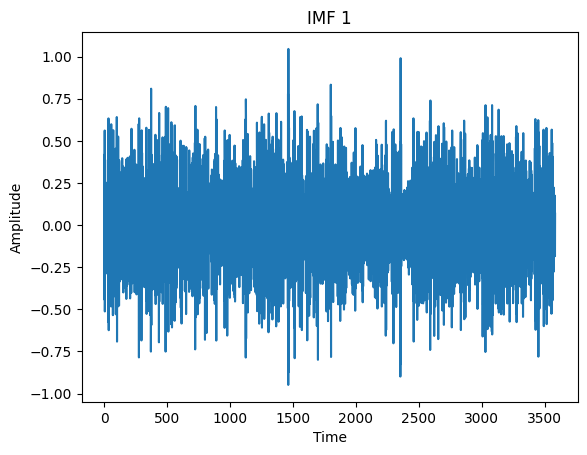

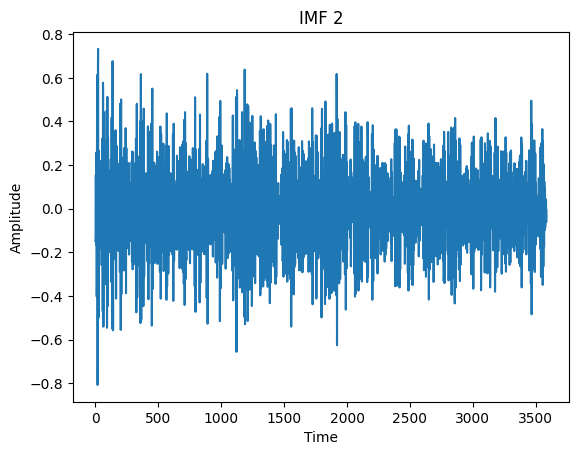

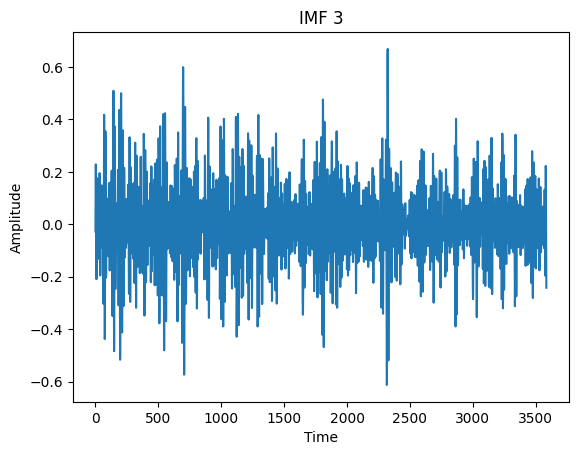

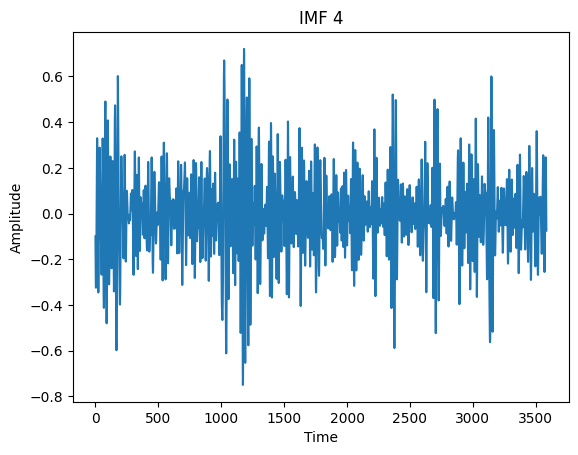

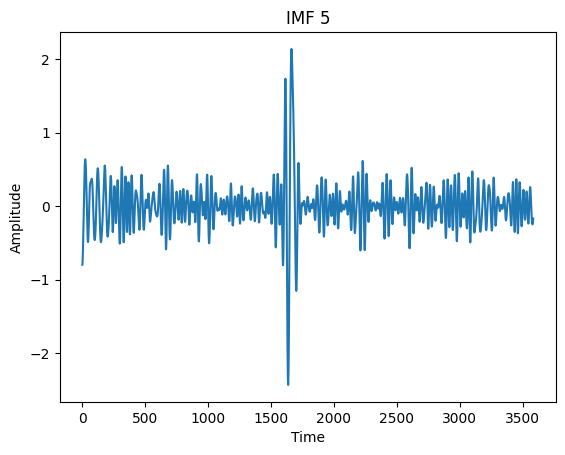

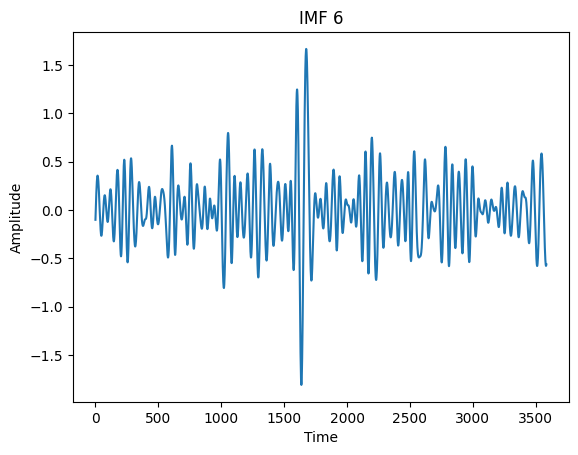

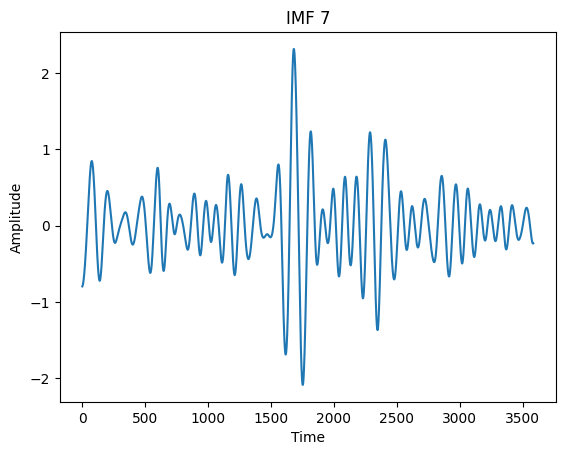

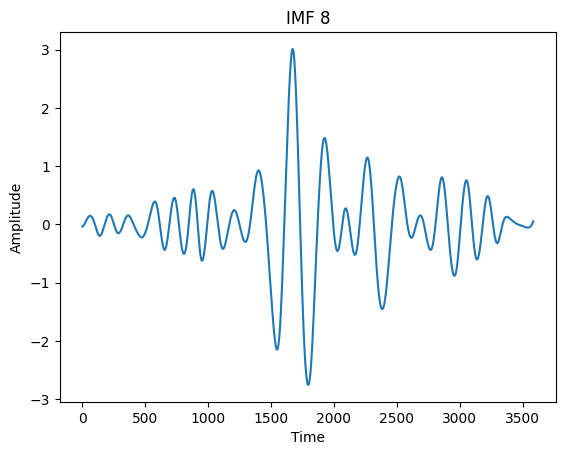

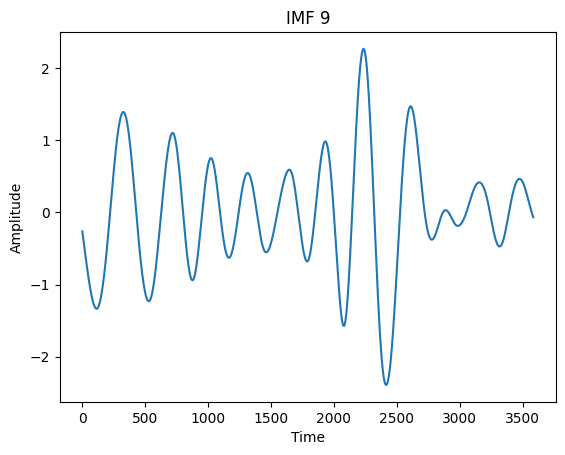

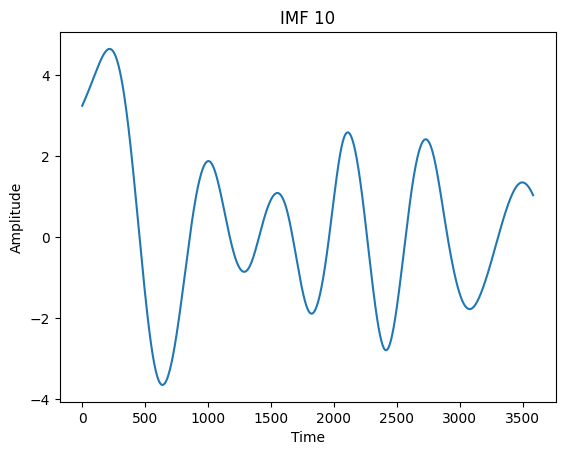

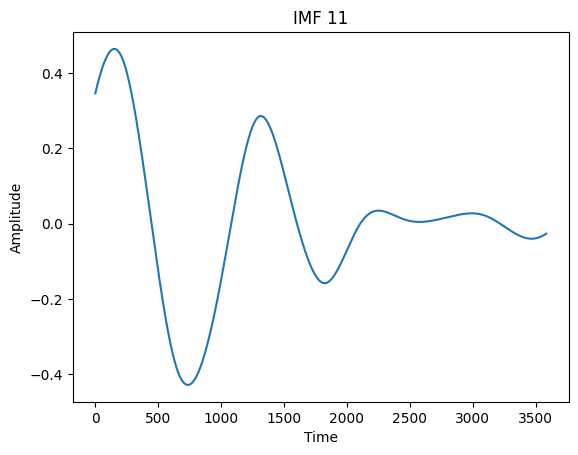

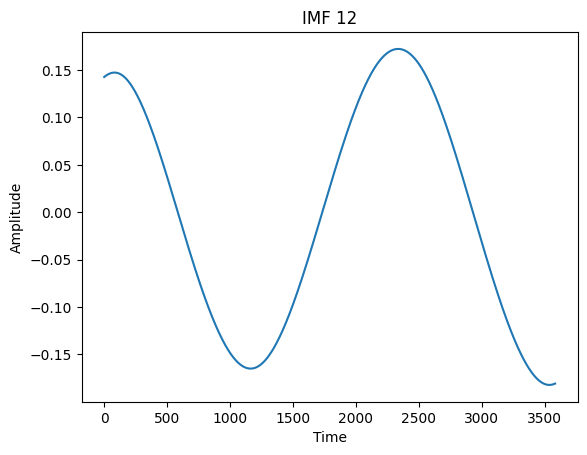

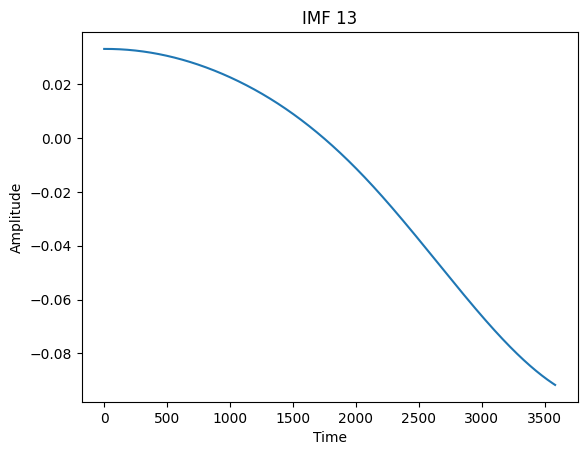

In [16]:
memd_imf = memd(erp_hands.data)
memd_imf_x = memd_imf[:,0,:] #imfs corresponding to 1st component
memd_imf_y = memd_imf[:,1,:] #imfs corresponding to 2nd component
memd_imf_z = memd_imf[:,2,:] #imfs corresponding to 3rd component


import matplotlib.pyplot as plt

for i in range(memd_imf_x.shape[0]):
    plt.figure()
    plt.plot(memd_imf_x[i,:])
    plt.title(f"IMF {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()


In [17]:
import scipy.io

data = {
    'erp_hands': erp_hands.data,
    'erps_feet': erp_feet.data
}
scipy.io.savemat('erp_data.mat', data)


In [37]:
# Load the MAT file
mat_data = scipy.io.loadmat('output_data.mat')

# Access individual arrays
u_hands = mat_data['u_hands']
u_hat_hands = mat_data['u_hat_hands']
omega_hands = mat_data['omega_hands']
u_feet = mat_data['u_feet']
u_hat_feet = mat_data['u_hat_feet']
omega_feet = mat_data['omega_feet']


###  Creating Spectrograms of Components

In [ ]:
from mne.time_frequency import tfr_morlet

def plot_morlet_spectogram(epochs, picks):
    freqs = np.logspace(*np.log10([1, 40]), num=40)
    n_cycles = freqs / 2.  # should be increasing to have constant frequency resolution

    power_feet = tfr_morlet(erp_feet, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False)
    power_hands = tfr_morlet(erp_hands, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False)

    for ch in picks:
        power_feet.plot([ch]) 
        power_hands.plot([ch])  

# Create direct spectrogram of ERP
plot_morlet_spectogram(erp_hands, picks)
plot_morlet_spectogram(erp_feet, picks)

# Create spectrogram of MEMD

# Create spectrogram of MVMD

